In [46]:
from  match_face import *
import numpy
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import yaml
from model import *
# Set random seed
rng = np.random.default_rng(seed=1234)

# Define paths
folder_vis = "../data/RGB_Thermal/rgb"
folder_ir = "../data/RGB_Thermal/thermal"

test_vis_path = "../data/test/vis"
test_ir_path = "../data/test/ir"

# Tạo thư mục đích nếu chưa có
os.makedirs(test_vis_path, exist_ok=True)
os.makedirs(test_ir_path, exist_ok=True)

In [47]:
# # Lấy danh sách tên ảnh trong folder_vis
# image_names = [f for f in os.listdir(folder_vis) if os.path.isfile(os.path.join(folder_vis, f))]

# # Shuffle
# image_names_array = np.array(image_names)
# rng.shuffle(image_names_array)

# # Lấy 200 ảnh đầu tiên
# selected_images = image_names_array[:200]

# # Di chuyển ảnh từ folder_vis và folder_ir sang test_vis_path và test_ir_path
# for img_name in selected_images:
#     src_vis = os.path.join(folder_vis, img_name)
#     src_ir = os.path.join(folder_ir, img_name)  # giả sử tên giống nhau
    
#     dst_vis = os.path.join(test_vis_path, img_name)
#     dst_ir = os.path.join(test_ir_path, img_name)

#     # Di chuyển và xoá
#     if os.path.exists(src_vis):
#         shutil.move(src_vis, dst_vis)
#     if os.path.exists(src_ir):
#         shutil.move(src_ir, dst_ir)


In [48]:
# Load configuration
with open('configs.yaml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)  # Use safe_load for security\
model_path = config['model']['path']
database_filename = config['embedding']['path']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = HyperFacePipeline().to(device)
if os.path.exists(model_path):
    print(f"Loading model from '{model_path}'...")
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    print("Model loaded.")
else:
    print(f"Model file not found at '{model_path}'.")
    exit()


def load_database_embeddings(filename):
    if not os.path.exists(filename):
        print(f"Error: Database file '{filename}' not found.")
        return None

    with open(filename, 'r') as f:
        data = json.load(f)

    db_embeddings = {}
    for person_id, values in data.items():
        if "embeddings_normalized" in values:
            db_embeddings[person_id] = np.array(values["embeddings_normalized"])
        else:
            print(f"Warning: ID '{person_id}' lacks 'embeddings_normalized'. Skipped.")
    return db_embeddings

database = load_database_embeddings(database_filename)

Using device: cpu
Loading model from './weights/hyperface_best_model.pth'...
Model loaded.


In [49]:
image_names = [f for f in os.listdir(test_vis_path) if os.path.isfile(os.path.join(test_ir_path, f))]
image_names[0:5]

['1-TD-A-6.jpg',
 '10-TD-E-1.jpg',
 '100-TD-A-3.jpg',
 '100-TD-A-6.jpg',
 '100-TD-E-4.jpg']

In [ ]:
# --- Hàm trích ID từ tên file ---
def extract_id_from_filename(filename):
    match = re.match(r"(\d+)-", filename)
    return match.group(1) if match else None

# --- Hàm đánh giá mô hình theo nhiều threshold ---
def evaluate_face_verification(model, ir_folder, vis_folder, database_embeddings, device, thresholds):
    all_similarities = []
    all_labels = []

    image_names = [f for f in os.listdir(vis_folder) if f.lower().endswith('.jpg')]

    for filename in tqdm(image_names, desc="Evaluating", leave= False):
        ir_path = os.path.join(ir_folder, filename)
        vis_path = os.path.join(vis_folder, filename)

        if not os.path.exists(ir_path) or not os.path.exists(vis_path):
            print(f"[SKIP] Missing IR or VIS image: {filename}")
            continue

        true_id = extract_id_from_filename(filename)
        if true_id is None:
            print(f"[WARN] Skipping file (can't extract ID): {filename}")
            continue

        matched_id, similarity = find_match(
            model, ir_path=ir_path, vis_path=vis_path,
            database_embeddings=database_embeddings, device=device, threshold=0
        )

        # Nếu ID nằm trong database thì là positive sample
        is_positive = true_id in database_embeddings
        label = 1 if is_positive else 0
        
        all_similarities.append(similarity)
        all_labels.append((label, matched_id, true_id))

    return compute_tar_far_frr(all_similarities, all_labels, thresholds)

# --- Hàm tính các chỉ số TAR / FAR / FRR ---
def compute_tar_far_frr(similarities, labels, thresholds):
    tar_list, far_list, frr_list = [], [], []

    for t in thresholds:
        TP = FP = FN = TN = 0

        for sim, (label, matched_id, true_id) in zip(similarities, labels):
            pred = 1 if sim >= t else 0

            if label == 1:  # Positive sample (người thật có trong DB)
                if pred == 1:
                    if matched_id == true_id:
                        TP += 1
                    else:
                        FP += 1  # Nhận nhầm thành người khác
                else:
                    FN += 1  # Từ chối sai
            else:
                if pred == 1:
                    FP += 1  # Nhận nhầm người ngoài
                else:
                    TN += 1  # Từ chối đúng người lạ

        TAR = TP / (TP + FN + 1e-6)
        FAR = FP / (FP + TN + 1e-6)
        FRR = FN / (TP + FN + 1e-6)

        print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
        tar_list.append(TAR)
        far_list.append(FAR)
        frr_list.append(FRR)

    return thresholds, tar_list, far_list, frr_list

# --- Hàm vẽ biểu đồ ---
def plot_metrics(thresholds, tar_list, far_list, frr_list):
    plt.figure(figsize=(10,6))
    plt.plot(thresholds, tar_list, label='TAR (True Accept Rate)')
    plt.plot(thresholds, far_list, label='FAR (False Accept Rate)')
    plt.plot(thresholds, frr_list, label='FRR (False Reject Rate)')
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title("TAR / FAR / FRR theo Threshold")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [56]:
thresholds = np.linspace(0.5, 0.9, 100)
thresholds, tar_list, far_list, frr_list = evaluate_face_verification(
    model=model,
    ir_folder=test_ir_path,
    vis_folder=test_vis_path,
    database_embeddings=database,
    device=device,
    thresholds=thresholds
)

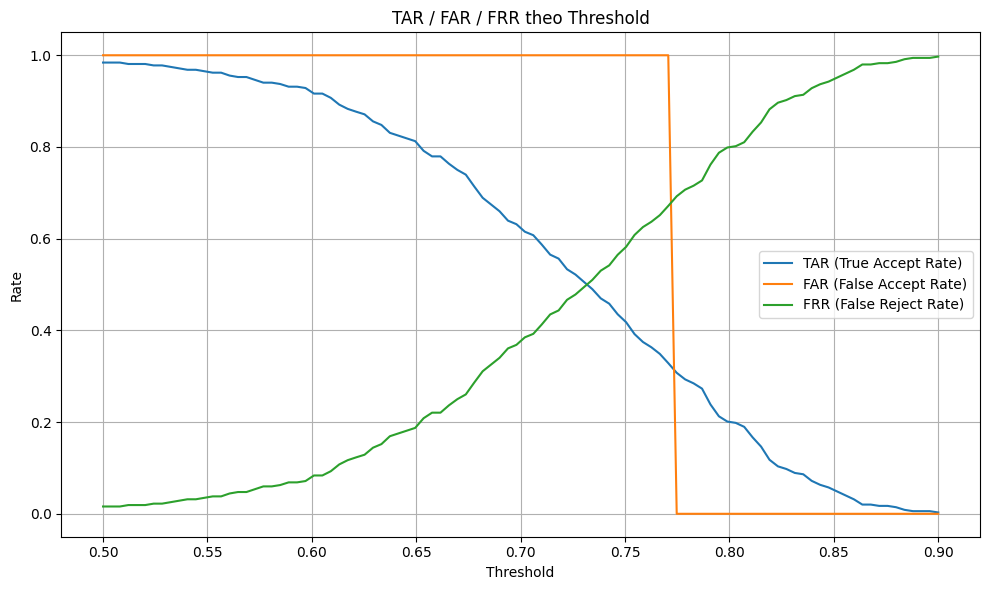

In [57]:
plot_metrics(thresholds, tar_list, far_list, frr_list)